MIMIC-IV - applying Garrett's intro code + looking more for ECMO and pneumonia cases



In [1]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import os
os.getcwd()

'/Users/catgaohow/OneDrive - Northwestern University/aaHBMI/HSIP 442 Yuan'

In [33]:
conn = psycopg2.connect(
    dbname="mimic4", user="student", host="luolabwkstn01.fsm.northwestern.edu", 
    port="5432",password='lipup')
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

GOAL: want to find all data for patients corresponding to core ECMO parameters:  rpm, flow, sweep, fdo2

### brainstorming possible label  names:
* vent params: tidal vol, resp rate, PEEP, FiO2
* core ECMO params: rpm, flow, sweep, fdo2

### what we know so far:
* from the MIMIC github of SQL code + past experiences, Garrett says  that ventilation info is often stored in mimiciii.chartevents table:
    * docs: 
        * https://mimic.mit.edu/docs/iii/tables/
        * https://github.com/geickelb/mimiciii-antibiotics-opensource/blob/master/src/SQL/ventsettings.sql
        * https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts
* this table is large and will likely need to be joined on others in order to find the data that corresponds to ECMO data. 

testing out running SQL query to the MIMIC server and exporting results to pandas:

In [10]:
icustay = query_schema + """
SELECT *
FROM mimiciv.icustays icu
limit 5
"""
icustay_df = pd.read_sql_query(icustay,conn) #38637
icustay_df
#need to filter careunit; if either first_careunit or last_careunit are MICU, keep?

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725
3,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2123-10-25 10:35:00,2123-10-25 18:59:47,0.350544
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2200-07-12 00:33:00,2200-07-13 16:44:40,1.674769


In [15]:
#what are all the different types of units?

df = query_schema + """
SELECT DISTINCT first_careunit 
FROM mimiciv.icustays icu
"""
df = pd.read_sql_query(df,conn) 
df
#keep MICU and MICU/SICU units? What about CCU?

,first_careunit
0,Neuro Intermediate
1,Medical Intensive Care Unit (MICU)
2,Trauma SICU (TSICU)
3,Neuro Surgical Intensive Care Unit (Neuro SICU)
4,Cardiac Vascular Intensive Care Unit (CVICU)
5,Neuro Stepdown
6,Coronary Care Unit (CCU)
7,Surgical Intensive Care Unit (SICU)
8,Medical/Surgical Intensive Care Unit (MICU/SICU)


In [ ]:
#how many people switch care units?
#count number where first does not equal last careunit

df = query_schema + """
SELECT COUNT first_careunit 
FROM mimiciv.icustays icu 
WHERE 
"""
df = pd.read_sql_query(df,conn) 
df



In [17]:
#what does chartevents look like

sql = query_schema + """
SELECT *
FROM mimiciv.chartevents ce
limit 5
"""
df = pd.read_sql_query(sql,conn) 
df


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220179,152,152.0,mmHg,0
1,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220180,97,97.0,mmHg,0
2,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220181,110,110.0,mmHg,0
3,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220045,65,65.0,bpm,0
4,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220210,14,14.0,insp/min,0


In [23]:
# add dimension table

sql = query_schema + """
SELECT *
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
limit 5
"""
df = pd.read_sql_query(sql,conn) #38637
df

#cool, gives us name (label) and abbreviation and category

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220179,152,152.0,mmHg,0,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
1,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220180,97,97.0,mmHg,0,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
2,10003700,28623837,30600691,2165-04-24 05:28:00,2165-04-24 05:37:00,220181,110,110.0,mmHg,0,220181,Non Invasive Blood Pressure mean,NBPm,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
3,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220045,65,65.0,bpm,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
4,10003700,28623837,30600691,2165-04-24 05:30:00,2165-04-24 05:37:00,220210,14,14.0,insp/min,0,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,None,None


In [29]:
# ok what are all the unique labels?
sql = query_schema + """
SELECT label
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
WHERE label LIKE '%Sweep%'
"""
df = pd.read_sql_query(sql,conn) 
df #cool, 13623 rows is way more than the 691 found in III

,label
0,Oxygenator Sweep Rate
1,Oxygenator Sweep Rate
2,Oxygenator Sweep Rate
3,Oxygenator Sweep Rate
4,Oxygenator Sweep Rate
...,...
13618,Sweep (ECMO)
13619,Sweep (ECMO)
13620,Sweep (ECMO)
13621,Sweep (ECMO)


In [30]:
df.label.value_counts() #why are there different names? 

Sweep (ECMO)             10059
Oxygenator Sweep Rate     2818
Sweep (CH)                 746
Name: label, dtype: int64

In [34]:
#what do sweep numbers look like? 

sql = query_schema + """
SELECT valuenum
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
WHERE di.label = 'Sweep (ECMO)' 
"""

df = pd.read_sql_query(sql,conn) 
df 

#booooo why do they all say none??

,valuenum
0,None
1,None
2,None
3,None
4,None
...,...
10054,None
10055,None
10056,None
10057,None


In [46]:
#what do sweep numbers look like? 
#hm, seems to be in 'value' not 'valuenum'
#also should check out category=ecmo
#what are all the different categories? 

sql = query_schema + """
SELECT *
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
WHERE di.label = 'Sweep (ECMO)' 
limit 5
"""

df = pd.read_sql_query(sql,conn) 
df 


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10612217,28651899,32097635,2163-11-18 20:00:00,2163-11-18 20:09:00,229278,2.0 L,None,None,0,229278,Sweep (ECMO),Sweep (ECMO),chartevents,ECMO,None,Text,None,None
1,10612217,28651899,32097635,2163-11-18 21:00:00,2163-11-18 20:49:00,229278,2.0 L,None,None,0,229278,Sweep (ECMO),Sweep (ECMO),chartevents,ECMO,None,Text,None,None
2,10612217,28651899,32097635,2163-11-18 22:00:00,2163-11-18 21:56:00,229278,2.0 L,None,None,0,229278,Sweep (ECMO),Sweep (ECMO),chartevents,ECMO,None,Text,None,None
3,10612217,28651899,32097635,2163-11-18 23:00:00,2163-11-18 22:53:00,229278,2.0 L,None,None,0,229278,Sweep (ECMO),Sweep (ECMO),chartevents,ECMO,None,Text,None,None
4,10612217,28651899,32097635,2163-11-19 00:00:00,2163-11-18 23:54:00,229278,2.0 L,None,None,0,229278,Sweep (ECMO),Sweep (ECMO),chartevents,ECMO,None,Text,None,None


In [53]:
#what do sweep numbers look like? 

sql = query_schema + """
SELECT value
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
WHERE di.label = 'Sweep (ECMO)' 
"""

df = pd.read_sql_query(sql,conn) 
df 



,value
0,2.0 L
1,2.0 L
2,2.0 L
3,2.0 L
4,2.0 L
...,...
10054,2.0 L
10055,2.0 L
10056,2.0 L
10057,3.0 L


In [54]:
#what's the difference between this one and the other documentation of ECMO?

df.describe()

,value
count,10059
unique,24
top,3.0 L
freq,1532


In [55]:

df.plot.hist(grid=False,
                   color='#607c8e')

#oops, have to convert to a number



TypeError: no numeric data to plot

In [57]:
df_value = pd.to_numeric(df)

TypeError: arg must be a list, tuple, 1-d array, or Series

In [35]:
#trying what another name looks like

sql = query_schema + """
SELECT valuenum
from mimiciv.chartevents ce
join mimiciv.d_items di 
    on di.itemid=ce.itemid
WHERE di.label = 'Oxygenator Sweep Rate' 
"""

df = pd.read_sql_query(sql,conn) 
df #

,valuenum
0,3.0
1,3.0
2,4.5
3,4.5
4,5.0
...,...
2813,1.5
2814,1.5
2815,1.5
2816,1.5


<AxesSubplot:ylabel='Frequency'>

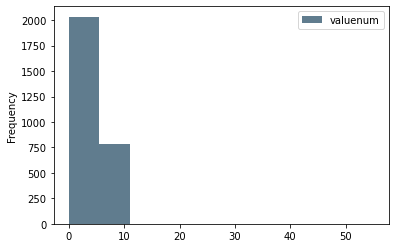

In [37]:

df.plot.hist(grid=False,
                   color='#607c8e')
#what's with the tail is there a random value at 50? 

In [40]:
df.describe()

,valuenum
count,2818.000000
mean,3.860717
std,2.269187
min,0.000000
25%,2.000000
50%,3.500000
75%,6.000000
max,55.000000


In [41]:
df['valuenum'].nlargest(n=5) #suspect was error should have been 5.5? drop this row

1542    55.0
742     10.0
743     10.0
744     10.0
745     10.0
Name: valuenum, dtype: float64

In [42]:
df=df.drop([1542, 1])

In [44]:
df['valuenum'].nlargest(n=5)

742    10.0
743    10.0
744    10.0
745    10.0
746    10.0
Name: valuenum, dtype: float64

<AxesSubplot:ylabel='Frequency'>

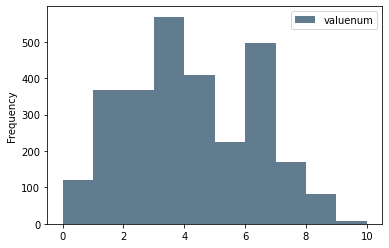

In [45]:

df.plot.hist(grid=False,
                   color='#607c8e')
#cool, this looks a lot better 

In [ ]:
# what are the other parameters at the time of this?
# what ICUs do these come from?
# can we tell VV vs VA ECMO?


In [51]:
#what are all the different types of categories?

df = query_schema + """
SELECT DISTINCT category 
FROM mimiciv.d_items
"""
df = pd.read_sql_query(df,conn) 
df

,category
0,Nutrition - Enteral
1,Nutrition - Supplements
2,Fluids - Other (Not In Use)
3,Skin - Assessment
4,Respiratory
...,...
74,Centrimag
75,Scores - APACHE II
76,Intubation
77,Paracentesis
